In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow as tf

import matplotlib.pyplot as plt
import pickle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-signs-preprocessed/label_names.csv
/kaggle/input/traffic-signs-preprocessed/valid.pickle
/kaggle/input/traffic-signs-preprocessed/datasets_preparing.py
/kaggle/input/traffic-signs-preprocessed/data7.pickle
/kaggle/input/traffic-signs-preprocessed/data2.pickle
/kaggle/input/traffic-signs-preprocessed/data4.pickle
/kaggle/input/traffic-signs-preprocessed/train.pickle
/kaggle/input/traffic-signs-preprocessed/data6.pickle
/kaggle/input/traffic-signs-preprocessed/mean_image_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/std_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/mean_image_gray.pickle
/kaggle/input/traffic-signs-preprocessed/test.pickle
/kaggle/input/traffic-signs-preprocessed/labels.pickle
/kaggle/input/traffic-signs-preprocessed/std_gray.pickle
/kaggle/input/traffic-signs-preprocessed/data3.pickle
/kaggle/input/traffic-signs-preprocessed/data0.pickle
/kaggle/input/traffic-signs-preprocessed/data5.pickle
/kaggle/input/traffic-signs-preprocessed/data1

In [12]:
# Directories
trainDir="../input/traffic-signs-preprocessed/train.pickle"
validDir="/kaggle/input/traffic-signs-preprocessed/valid.pickle"
testDir="/kaggle/input/traffic-signs-preprocessed/test.pickle"

In [13]:
# Reading Pickle Files
trainHand=open(trainDir,'rb')
trainHand=pickle.load(trainHand)
#print(trainHand)
testHand=open(testDir,'rb')
testHand=pickle.load(testHand)
validHand=open(validDir,'rb')
validHand=pickle.load(validHand)


In [14]:
# extracting labels and images from pickled data
train_images, train_labels= trainHand['features'],trainHand['labels'] #imagesize(37499,32,32,3) label_size=(37499,)
test_images, test_labels= testHand['features'],testHand['labels'] 
valid_images, valid_labels= validHand['features'],validHand['labels'] 
class_types=len(set(train_labels))
print(len(train_images))
#plt.imshow(images[3000])
#plt.show()

34799


In [15]:
# Normalizing Images
train_images=train_images/255
test_images=test_images/255
valid_images=valid_images/255

In [16]:
# Not used in the provided code
# Extra feature for preprocessing images
import cv2
'''def preProc(images):
    grayScaled=[cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)/255 for image in images]
    
    return grayScaled

train_images=preProc(train_images)
test_images=preProc(test_images)
valid_images=preProc(valid_images)'''

'def preProc(images):\n    grayScaled=[cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)/255 for image in images]\n    \n    return grayScaled\n\ntrain_images=preProc(train_images)\ntest_images=preProc(test_images)\nvalid_images=preProc(valid_images)'

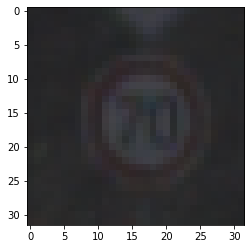

In [17]:
# Displays Image
plt.imshow(train_images[7000])
plt.show()
#print(len(train_images[7000]))

In [18]:
# TensorFlow Sequential Model
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(class_types,activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [19]:
# Creates Batches of Input Data
def batchData(features,labels,BATCH_SIZE):
    X_items=[]
    tempX=[]
    Y_items=[]
    tempY=[]
    for items in features:
        tempX+=[items]
        if len(tempX)==BATCH_SIZE:
            X_items+=tempX
            tempX=[]
    for items in labels:
        tempY+=[items]
        if len(tempY)==BATCH_SIZE:    
            Y_items+=tempY
            tempY=[]
    return X_items,Y_items


In [20]:
# Creating Batches using batchData Function
trainData, trainLabels = batchData(train_images,train_labels,64)
validData, validLabels = batchData(valid_images,valid_labels,64)

In [21]:
# Defining Callback object
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=[]):
        if logs.get('val_loss') < 0.3:
            print('Validation Accuracy Achieved')
            self.model.stop_training=True
callback=myCallback()

In [22]:
# Fitting on Training Data
if 'trainedModel.h5' in os.listdir('/kaggle/'):
    model.load_weights('/kaggle/trainedModel.h5')
    
else:
    history=model.fit(np.array(trainData),np.array(trainLabels),epochs=10,steps_per_epoch=37499//64,
                  validation_data=(np.array(validData),np.array(validLabels)),callbacks=[callback])
    model.save_weights('/kaggle/working/trainedModel.h5')

Epoch 1/10
585/585 [==============================] - 70s 120ms/step - loss: 2.8541 - accuracy: 0.2709 - val_loss: 2.3161 - val_accuracy: 0.4122
Epoch 2/10
585/585 [==============================] - 69s 119ms/step - loss: 1.5024 - accuracy: 0.5894 - val_loss: 1.4193 - val_accuracy: 0.6126
Epoch 3/10
585/585 [==============================] - 68s 116ms/step - loss: 0.8417 - accuracy: 0.7690 - val_loss: 1.0178 - val_accuracy: 0.7183
Epoch 4/10
585/585 [==============================] - 68s 117ms/step - loss: 0.4937 - accuracy: 0.8682 - val_loss: 0.7835 - val_accuracy: 0.8116
Epoch 5/10
585/585 [==============================] - 69s 119ms/step - loss: 0.3057 - accuracy: 0.9200 - val_loss: 0.6699 - val_accuracy: 0.8274
Epoch 6/10
585/585 [==============================] - 70s 119ms/step - loss: 0.2004 - accuracy: 0.9481 - val_loss: 0.7203 - val_accuracy: 0.8408
Epoch 7/10
585/585 [==============================] - 69s 118ms/step - loss: 0.1418 - accuracy: 0.9647 - val_loss: 0.5866 - val_ac

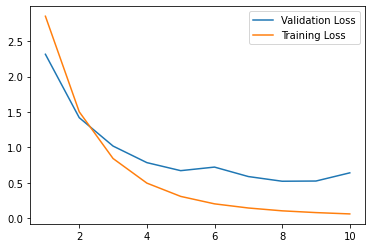

In [23]:
# Displays Validation and Training Loss to manually observe overfitting
plt.plot(np.arange(1,11),history.history['val_loss'],label='Validation Loss')
plt.plot(np.arange(1,11),history.history['loss'],label='Training Loss')
plt.legend()

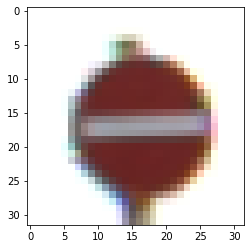

In [62]:
# Displays Test Image
plt.imshow(test_images[560])
plt.show()

In [43]:
import csv
csvfile=open('/kaggle/input/traffic-signs-preprocessed/label_names.csv')
data=csv.reader(csvfile,delimiter=',')
next(data)
dt={}
for row in data:
    dt.update({row[0]:row[1]})

In [63]:
# predicts the image label
x=(np.argmax(model.predict(test_images)[560]))


In [64]:
print(dt[str(x)])
print(x)

No entry
17
